#### Libraries

In [4]:
# basic libraries

import warnings

warnings.filterwarnings("ignore")  # category=DeprecationWarning
import os

# Mise en page
import jupyter_black

jupyter_black.load()

In [6]:
import pandas as pd
import zipfile
import io
from dask import dataframe as df1
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings
from sklearn.decomposition import PCA
from fanalysis.pca import PCA as PCA_A
from sklearn.metrics import silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer

In [7]:
# Set up path

PATH = os.path.join(os.getcwd(), "data")

### Loading the data

In [3]:
#!pip install dask

In [9]:
# We import the dataset and record the time needed for importing it.

from dask import dataframe as dd
import time

# time taken to read data
s_time_dask = time.time()
dask_df = dd.read_csv(
    "COVID19_twitter_full_dataset.csv",  # , blocksize="400mb"
    # index_col=0,
)

# Set the index column after reading the CSV
# dask_df = dask_df.set_index("Unnamed: 0")
# dask_df = dask_df.drop(columns=["Unnamed: 0"])

e_time_dask = time.time()

print("Read with dask: ", (e_time_dask - s_time_dask), "seconds")

# data
dask_df.head(10)

Read with dask:  0.014497041702270508 seconds


,tweet_id,user_id,tweet_timestamp,keyword,country/region,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion
0,1221957211913457664,1319491585,2020-01-27 16-44-36,wuhan,Malaysia,0.336,0.575,0.505,0.184,0.507,negative,fear
1,1221957309829545985,1629375746,2020-01-27 16-45-00,wuhan,Malaysia,0.445,0.470,0.403,0.263,0.395,negative,fear
2,1221957488158789632,894465432,2020-01-27 16-45-42,wuhan,-,0.265,0.718,0.572,0.218,0.694,very negative,fear
3,1221957499730812929,165242082,2020-01-27 16-45-45,wuhan,-,0.362,0.770,0.506,0.200,0.586,negative,fear
4,1221957853482835968,735428110917722112,2020-01-27 16-47-09,wuhan,NaN,0.528,0.542,0.497,0.388,0.488,positive,happiness
5,1221958163785601024,1173417894585102337,2020-01-27 16-48-23,wuhan,NaN,0.365,0.624,0.489,0.221,0.509,negative,fear
6,1221958334661779458,18527874,2020-01-27 16-49-04,wuhan,United States,0.513,0.550,0.358,0.364,0.344,neutral or mixed,no specific emotion
7,1221958989472075777,1055322345982722049,2020-01-27 16-51-40,wuhan,NaN,0.391,0.533,0.472,0.228,0.467,negative,fear
8,1221959334793342976,1208960120320745472,2020-01-27 16-53-02,wuhan,NaN,0.632,0.372,0.286,0.495,0.406,positive,happiness
9,1221959351461720064,35527998,2020-01-27 16-53-06,wuhan,United States,0.526,0.387,0.421,0.364,0.368,positive,happiness


In [10]:
# We made a copy of the dataframe for convenience.

ddf_2 = dask_df.copy()

In [11]:
ddf_2.columns

Index(['tweet_id', 'user_id', 'tweet_timestamp', 'keyword', 'country/region',
       'valence_intensity', 'fear_intensity', 'anger_intensity',
       'happiness_intensity', 'sadness_intensity', 'sentiment', 'emotion'],
      dtype='object')

### Question 3

In [12]:
# Before performing stratified sampling, we take a look at the counts of each sentiments.

ddf_2["sentiment"].value_counts().compute()

sentiment
negative            108754878
positive             47305568
neutral or mixed     30787429
very negative        10078046
very positive         1452263
Name: count, dtype: int64

In [13]:
# As instrcuted, three classes are required only, so we replaced the classes with 'negative', 'positive', and neutral.

ddf_2["sentiment"] = ddf_2["sentiment"].replace("very negative", "negative")
ddf_2["sentiment"] = ddf_2["sentiment"].replace("very positive", "positive")
ddf_2["sentiment"] = ddf_2["sentiment"].replace("neutral or mixed", "neutral")

In [14]:
# Here is the new value counts of the classes.

ddf_2["sentiment"].value_counts().compute()

sentiment
negative    118832924
positive     48757831
neutral      30787429
Name: count, dtype: int64

In [15]:
# For quicker computation, we worked on the classes separately. Three separate datasets are created.

ddf_negative = ddf_2.copy()
ddf_negative = ddf_negative[ddf_negative["sentiment"] == "negative"]

In [16]:
ddf_positive = ddf_2.copy()
ddf_positive = ddf_positive[ddf_positive["sentiment"] == "positive"]

In [17]:
ddf_neutral = ddf_2.copy()
ddf_neutral = ddf_neutral[ddf_neutral["sentiment"] == "neutral"]

In [18]:
# We perform train-test splits with shuffle three times to do the stratified sampling.

from dask_ml.model_selection import train_test_split

ddf_negative_train, ddf_negative_test = train_test_split(
    ddf_negative,
    random_state=0,
    test_size=0.2,
    shuffle=True,  # , stratify=ddf_2["sentiment"]
)

In [19]:
from dask_ml.model_selection import train_test_split

ddf_positive_train, ddf_positive_test = train_test_split(
    ddf_positive,
    random_state=0,
    test_size=0.2,
    shuffle=True,  # , stratify=ddf_2["sentiment"]
)

In [20]:
from dask_ml.model_selection import train_test_split

ddf_neutral_train, ddf_neutral_test = train_test_split(
    ddf_neutral,
    random_state=0,
    test_size=0.2,
    shuffle=True,  # , stratify=ddf_2["sentiment"]
)

In [21]:
# After that, we concat all the three datasets together as the final dataset for performing the following steps.

ddf_test = dd.concat([ddf_negative_test, ddf_positive_test, ddf_neutral_test])

In [22]:
type(ddf_test)

dask.dataframe.core.DataFrame

In [23]:
# Here is the result of the proportionate sampling.

ddf_test["sentiment"].value_counts().compute()

sentiment
negative    23764011
positive     9748800
neutral      6157338
Name: count, dtype: int64

In [24]:
ddf_test.head(3)

,tweet_id,user_id,tweet_timestamp,keyword,country/region,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion
526868,1224967305953566722,180030853,2020-02-05 00-05-39,wuhan,NaN,0.445,0.452,0.418,0.312,0.470,negative,sadness
397914,1223963883162857472,2267311,2020-02-02 05-38-24,corona,India,0.329,0.737,0.456,0.196,0.518,negative,fear
415666,1224059212373921792,881731669874548736,2020-02-02 11-57-12,wuhan,New Zealand,0.474,0.501,0.403,0.303,0.411,negative,fear


In [26]:
# So as we have done in the previous questions, we only used the intensity values to perform clustering and PCA.

ddf_test = ddf_test[
    [
        "valence_intensity",
        "fear_intensity",
        "anger_intensity",
        "happiness_intensity",
        "sadness_intensity",
    ]
]

In [27]:
ddf_test.head(3)

,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity
526868,0.445,0.452,0.418,0.312,0.470
397914,0.329,0.737,0.456,0.196,0.518
415666,0.474,0.501,0.403,0.303,0.411


In [29]:
# Now, we handle the remaining 80%.

ddf_train = dd.concat([ddf_negative_train, ddf_positive_train, ddf_neutral_train])
ddf_train = ddf_train[
    [
        "valence_intensity",
        "fear_intensity",
        "anger_intensity",
        "happiness_intensity",
        "sadness_intensity",
    ]
]

In [30]:
type(ddf_train)

dask.dataframe.core.DataFrame

In [31]:
ddf_train.head(3)

,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity
457817,0.434,0.264,0.356,0.275,0.277
123585,0.477,0.478,0.323,0.267,0.348
111033,0.402,0.486,0.517,0.202,0.436


### Perform PCA

In [33]:
# Chat

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd


def pca_analysis_data(data):

    # Standardize the data
    metric_pca = (data - data.mean()) / data.std()

    # Perform PCA
    pca = PCA()
    pca.fit(metric_pca)

    # Explained variance
    explained_variance = pca.explained_variance_ratio_
    print(explained_variance)

    # Plot the eigenvalues
    plt.figure(figsize=(8, 5))
    plt.bar(
        range(1, len(explained_variance) + 1),
        explained_variance * 100,
        alpha=0.7,
        align="center",
    )
    plt.step(
        range(1, len(explained_variance) + 1),
        explained_variance.cumsum() * 100,
        where="mid",
        color="red",
    )
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained (%)")
    plt.title("Explained Variance by Different Principal Components")
    plt.show()

    # Transform the dataset using PCA
    pca_dataset = pca.transform(metric_pca)

    return pca, pca_dataset

[0.81034611 0.08300655 0.05995293 0.03225383 0.01444058]


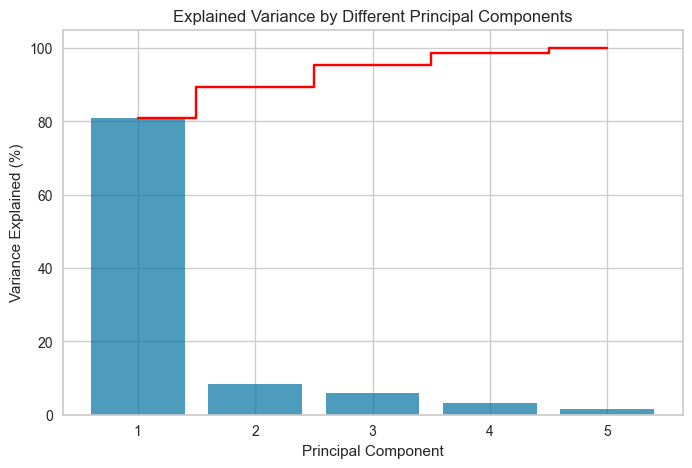

In [34]:
# We run the PCA function, and find out that the first component explain more than 80% of the variance.

pca_values, pca_dataset = pca_analysis_data(ddf_test)

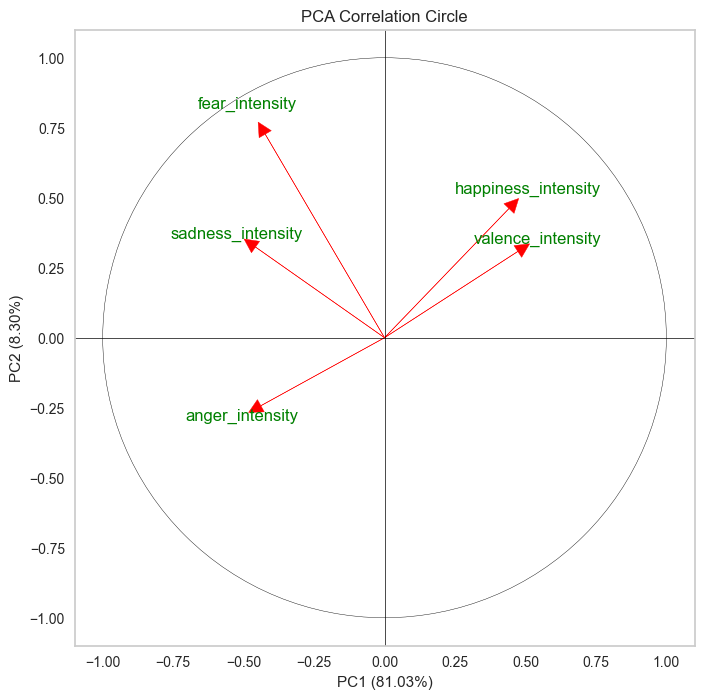

In [36]:
def plot_pca_correlation_circle(pca, data):
    pcs = pca.components_
    n_features = data.shape[1]
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the circle
    circle = plt.Circle((0, 0), 1, color="black", fill=False)
    ax.add_artist(circle)

    for i in range(n_features):
        plt.arrow(
            0,
            0,
            pcs[0, i],
            pcs[1, i],
            head_width=0.05,
            head_length=0.05,
            fc="red",
            ec="red",
        )
        plt.text(
            pcs[0, i] * 1.15,
            pcs[1, i] * 1.15,
            data.columns[i],
            color="green",
            ha="center",
            va="center",
        )

    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
    plt.grid()
    plt.axhline(0, color="black", lw=0.5)
    plt.axvline(0, color="black", lw=0.5)
    plt.title("PCA Correlation Circle")
    plt.show()


plot_pca_correlation_circle(pca_values, ddf_test)

In [42]:
# On PC1, the negative emotions are on the left with negative values while the positive emotions are on the right.
# On PC2, it divides the negative emotions with fear and sadness on the upper left while anger at the lower left.

### KMeans Clustering

In [43]:
pca_df = pd.DataFrame(pca_dataset, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
pca_df.head()

,PC1,PC2,PC3,PC4,PC5
0,-0.175896,0.381635,-0.045623,0.617051,-0.032753
1,-3.020485,1.697501,-1.193290,-0.446275,-0.465433
2,0.117045,0.608243,-0.452296,-0.174471,-0.037766
3,-3.414305,1.614810,0.019764,-0.242385,0.120980
4,-1.330856,1.921498,-0.167774,-0.049211,0.199278


In [50]:
# Convert the Dask DataFrame to a Pandas DataFrame

pandas_df_test = ddf_test.compute()
print(type(pandas_df_test))

<class 'pandas.core.frame.DataFrame'>


#! pip install --upgrade scikit-learn threadpoolctl

#import os
#os.environ["OPENBLAS_NUM_THREADS"] = "1"

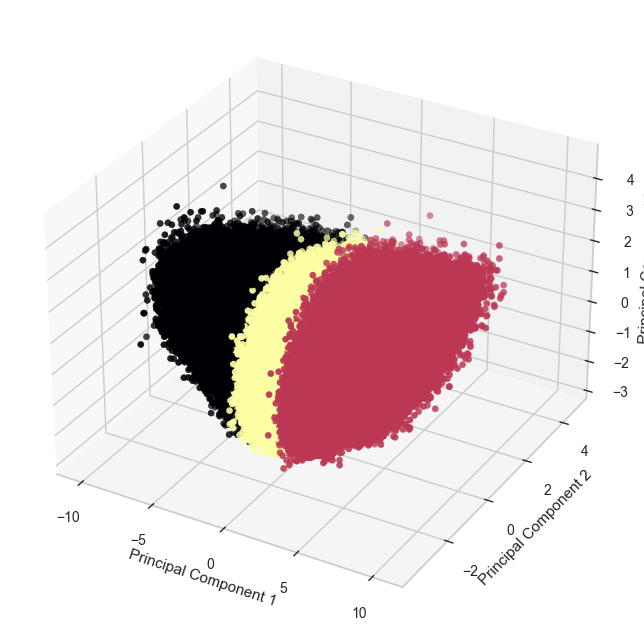

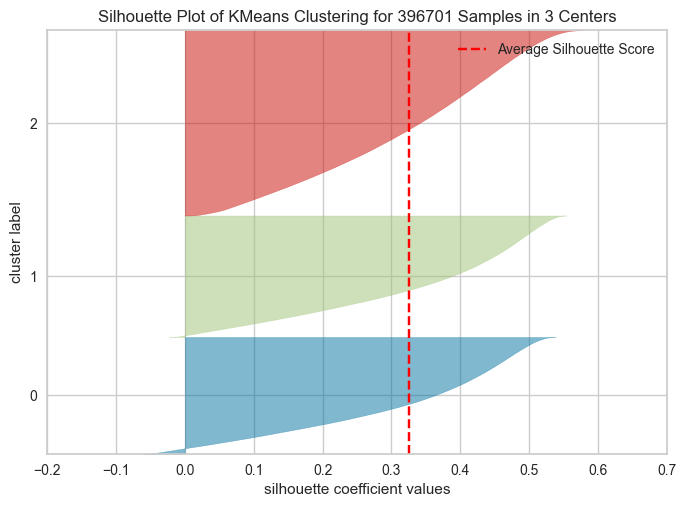

        valence_intensity  fear_intensity  anger_intensity  \
526868              0.445           0.452            0.418   
397914              0.329           0.737            0.456   
415666              0.474           0.501            0.403   
318394              0.362           0.704            0.555   
37391               0.466           0.636            0.449   

        happiness_intensity  sadness_intensity  Cluster  
526868                0.312              0.470        2  
397914                0.196              0.518        0  
415666                0.303              0.411        2  
318394                0.218              0.574        0  
37391                 0.306              0.516        0  
        PC1       PC2       PC3       PC4       PC5  Cluster
0 -0.175896  0.381635 -0.045623  0.617051 -0.032753        2
1 -3.020485  1.697501 -1.193290 -0.446275 -0.465433        0
2  0.117045  0.608243 -0.452296 -0.174471 -0.037766        2
3 -3.414305  1.614810  0.019764 -0.

In [57]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
from mpl_toolkits.mplot3d import Axes3D


def clustering_data(dataset, number_cluster, data_fig):
    """
    Perform K-Means clustering on the dataset, visualize the clusters, and compute cluster centroids.

    Parameters:
    dataset (pd.DataFrame): The input dataset for clustering.
    number_cluster (int): The number of clusters.
    data_fig (pd.DataFrame): The dataset transformed by PCA.

    Returns:
    tuple: A tuple containing the final dataset with cluster assignments,
           the DataFrame with clusters, and the DataFrame with cluster centroids.
    """
    kmeans = KMeans(n_clusters=number_cluster, random_state=42)
    kmeans.fit(dataset)
    y = kmeans.labels_

    df_k = data_fig.assign(Cluster=y)

    # Compute centroids
    centroids = kmeans.cluster_centers_
    titles = dataset.columns
    centroids_df = pd.DataFrame(centroids, columns=titles)
    centroids_indexed = centroids_df.reset_index().rename(
        {"index": "Cluster"}, axis="columns"
    )

    final_data = dataset.assign(Cluster=y)

    # 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(df_k.iloc[:, 0], df_k.iloc[:, 1], df_k.iloc[:, 2], c=y, cmap="inferno")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    plt.show()

    # Silhouette plot
    dataset_sample = dataset.sample(frac=0.01, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors="yellowbrick")
    visualizer.fit(dataset_sample)
    visualizer.show()

    return final_data, df_k, centroids_indexed


# Example usage:
# Assuming pca_dataset and ddf_test are already defined
final_data_3, df_k_3, centroids_3 = clustering_data(pandas_df_test, 3, pca_df)
print(final_data_3.head())
print(df_k_3.head())
print(centroids_3.head())

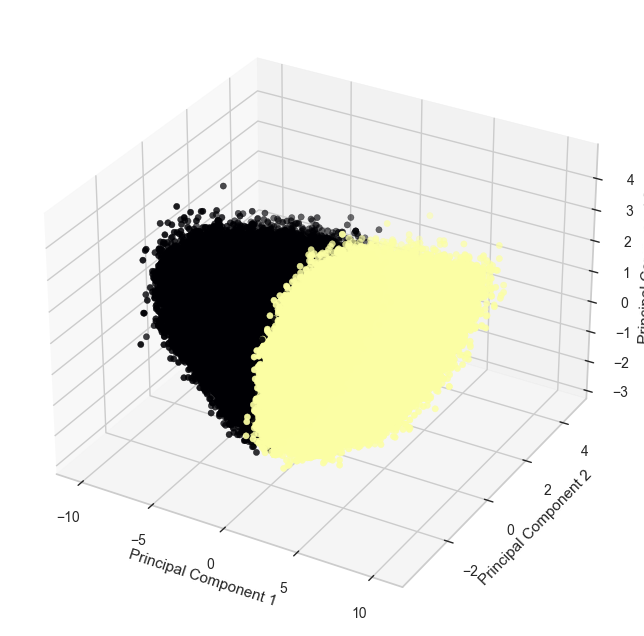

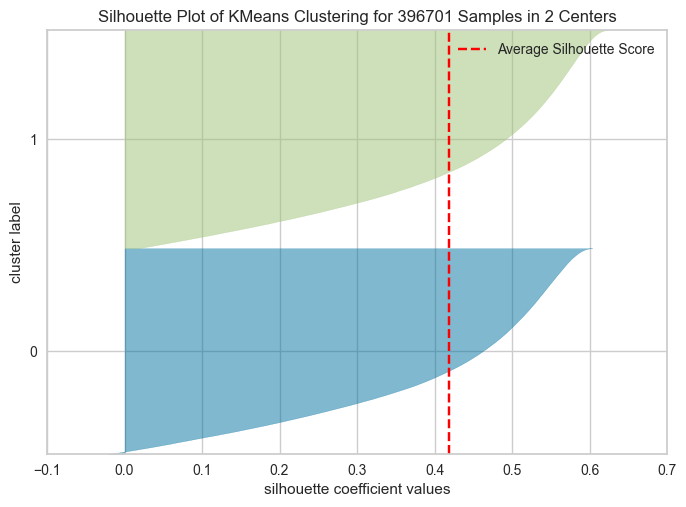

        valence_intensity  fear_intensity  anger_intensity  \
526868              0.445           0.452            0.418   
397914              0.329           0.737            0.456   
415666              0.474           0.501            0.403   
318394              0.362           0.704            0.555   
37391               0.466           0.636            0.449   

        happiness_intensity  sadness_intensity  Cluster  
526868                0.312              0.470        0  
397914                0.196              0.518        0  
415666                0.303              0.411        1  
318394                0.218              0.574        0  
37391                 0.306              0.516        0  
        PC1       PC2       PC3       PC4       PC5  Cluster
0 -0.175896  0.381635 -0.045623  0.617051 -0.032753        0
1 -3.020485  1.697501 -1.193290 -0.446275 -0.465433        0
2  0.117045  0.608243 -0.452296 -0.174471 -0.037766        1
3 -3.414305  1.614810  0.019764 -0.

In [114]:
final_data_2, df_k_2, centroids_2 = clustering_data(pandas_df_test, 2, pca_df)

print(final_data_2.head())
print(df_k_2.head())
print(centroids_2.head())

### Homogeneity score before assigning the remaining (k=3)

In [61]:
# True labels - Test

ddf_test_sentiment = dd.concat([ddf_negative_test, ddf_positive_test, ddf_neutral_test])

ddf_test_labels = ddf_test_sentiment["sentiment"].compute()

In [73]:
type(ddf_test_labels)

pandas.core.series.Series

In [ ]:
ddf_test_labels = ddf_test_labels.replace("negative", 0)
ddf_test_labels = ddf_test_labels.replace("positive", 1)
ddf_test_labels = ddf_test_labels.replace("neutral", 2)
# ddf_test_labels = ddf_test_labels.astype(float)

In [ ]:
ddf_test_labels

In [85]:
# Fit KMeans model
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pandas_df_test)

# Initial clustering labels
initial_labels_3 = kmeans.labels_

In [87]:
from sklearn.metrics.cluster import homogeneity_score

# Initial clustering labels

initial_labels_3 = kmeans.labels_

# Calculate initial homogeneity score before

homogeneity_initial_3 = homogeneity_score(ddf_test_labels, initial_labels_3)
homogeneity_initial_3

0.4623777069270009

### Cosine Similarity and Assign the Remaining to Clusters (k=3)

In [89]:
# Convert the Dask DataFrame to a Pandas DataFrame

pandas_df_train = ddf_train.compute()
print(type(pandas_df_train))

<class 'pandas.core.frame.DataFrame'>


In [99]:
# Assign clusters using cosine similarity
def assign_clusters(remaining_data, centroids):
    clusters = []
    for point in remaining_data.values:  # ensure point is a 1-D array
        similarities = [1 - cosine(point, centroid.flatten()) for centroid in centroids]
        assigned_cluster = np.argmax(similarities)
        clusters.append(assigned_cluster)
    return clusters

In [108]:
from joblib import Parallel, delayed
from scipy.spatial.distance import cosine
import numpy as np


# Function to calculate the assigned cluster for a single point
def assign_single_cluster(point, centroids):
    point = point.flatten()  # Ensure the point is 1-D
    similarities = [1 - cosine(point, centroid.flatten()) for centroid in centroids]
    return np.argmax(similarities)


# Assign clusters using parallel processing
def assign_clusters_parallel(data, centroids, n_jobs=-1):
    clusters = Parallel(n_jobs=n_jobs)(
        delayed(assign_single_cluster)(point, centroids) for point in data.values
    )
    return clusters


def assign_clusters_batch(data, centroids, batch_size=1000, n_jobs=-1):
    def process_batch(batch):
        return [assign_single_cluster(point, centroids) for point in batch]

    num_batches = int(np.ceil(len(data) / batch_size))
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_batch)(data.iloc[i * batch_size : (i + 1) * batch_size].values)
        for i in range(num_batches)
    )
    return np.concatenate(results)


# Calculate centroids
centroids_3 = kmeans.cluster_centers_

# Convert remaining data to pandas DataFrame if it's a Dask DataFrame
pandas_remaining_data = (
    pandas_df_train  # Assuming pandas_df_train is the remaining data
)

# Assign remaining data to clusters using batch processing
assigned_clusters_3 = assign_clusters_batch(pandas_remaining_data, centroids_3)

# Output results
print("Clusters for k=3:", assigned_clusters_3)

Clusters for k=3: [1 2 0 ... 1 1 1]


### Cosine Similarity and Assign the Remaining to Clusters (k=2)

In [115]:
# Fit KMeans model
kmeans_2 = KMeans(n_clusters=2, random_state=42)
kmeans_2.fit(pandas_df_test)

KMeans(n_clusters=2, random_state=42)

In [116]:
# Calculate centroids
centroids_2 = kmeans_2.cluster_centers_

# Assign remaining data to clusters using batch processing
assigned_clusters_2 = assign_clusters_batch(pandas_remaining_data, centroids_2)

# Output results
print("Clusters for k=2:", assigned_clusters_2)

Clusters for k=2: [1 1 0 ... 1 1 1]


### Homogeneity score after assigning the remaining 80%

In [110]:
# True labels - Train

ddf_train_sentiment = dd.concat(
    [ddf_negative_train, ddf_positive_train, ddf_neutral_train]
)

ddf_train_labels = ddf_train_sentiment["sentiment"].compute()

In [111]:
ddf_train_labels = ddf_train_labels.replace("negative", 0)
ddf_train_labels = ddf_train_labels.replace("positive", 1)
ddf_train_labels = ddf_train_labels.replace("neutral", 2)

In [112]:
# Combined labels for homogeneity score calculation

combined_labels_3 = np.concatenate([initial_labels_3, assigned_clusters_3])

# Combined true labels

combined_true_labels = np.concatenate([ddf_test_labels, ddf_train_labels])

In [113]:
# Calculate homogeneity score after assigning remaining data points

homogeneity_final_3 = homogeneity_score(combined_true_labels, combined_labels_3)
print("Final Homogeneity Score for k=3:", homogeneity_final_3)

Final Homogeneity Score for k=3: 0.47171528465364654
